<a href="https://colab.research.google.com/github/Sobhan-Gh/Graph-state-functions/blob/main/LC_equivalence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import networkx as nx
import random
from itertools import combinations
from itertools import permutations
import warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
#produce random pair of graphs with 'n' vertices until you find a pair that are LC equal. 
def tester(n):
    solution=1
    while not isinstance(solution,type(np.array([0]))):
        row=0
        G1, G2 = nx.fast_gnp_random_graph(n,0.65), nx.fast_gnp_random_graph(n,0.65)

        z_1=nx.to_numpy_array(G1).astype(int)
        z_2=nx.to_numpy_array(G2).astype(int)

        solution=solver(z_1, z_2, Mode='deterministic')

 

        if isinstance(solution,type(np.array([0]))):
            plt.figure(1)
            nx.draw(G1, with_labels = True)    
            plt.figure(2)
            nx.draw(G2, with_labels = True) 
            print(Local_Clifford_ops(solution),"\n")
        else: 
            clear_output(wait=True)

    return solution, (G1, G2)

In [3]:
def coeff_maker(z_1, z_2):
    row=0
    n=np.shape(z_1)[0]
    assert (np.shape(z_1)[0] == np.shape(z_2)[0]),"graphs must be of same size"

    coeff_matrix=np.zeros((n**2,4*n)).astype(int)
    for j in range(n):
        for k in range(n):
            for m in range(n):
                row = (n*j+k)
                #a_m
                if m == k: 
                  coeff_matrix[row,4*m+0] = z_1[j,k] 
                #b_m
                if (m == k and j == k): 
                  coeff_matrix[row,4*m+1] = 1
                #c_m
                coeff_matrix[row,4*m+2] = z_1[m,j] * z_2[m,k]
                #d_m
                if m == j: 
                  coeff_matrix[row,4*m+3] = z_2[j,k]
    return coeff_matrix%2

In [4]:
#row reduction function
def RowSwap(X,i,j):
  X[[i,j]]=X[[j,i]]
  return X

def Add_Rows(X,i,j):
  X[j]=(X[i]+X[j])%2
  return X
#Returns the row reduced matrix X, the transformed matrix Z and the rank-1
def RowRed(X,Z,pivot):
  n,m=np.shape(X)
  rank=0
  if pivot[1]==(m-1):
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    if not the_ones:
        pivot[0]=pivot[0]-1 #empty under and including pivot on last column 
    else:
        X=RowSwap(X,the_ones[0],pivot[0])
        Z=RowSwap(Z,the_ones[0],pivot[0])
        the_ones.remove(the_ones[0])
        for b in the_ones:
          X=Add_Rows(X,pivot[0],b)
          Z=Add_Rows(Z,pivot[0],b)
    return X,Z,pivot[0]
  elif pivot[0]==(n-1):
    if X[pivot[0],pivot[1]] == 1:
      return X,Z,pivot[0]
    else:
      pivot=[pivot[0],pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)

  else:
    #list of rows with value 1 under the pivot element
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    #check if the column below is empty to skip it
    if not the_ones:
      pivot=[pivot[0],pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)
    else:
      X=RowSwap(X,the_ones[0],pivot[0])
      Z=RowSwap(Z,the_ones[0],pivot[0])
      the_ones.remove(the_ones[0])
      for b in the_ones:
        X=Add_Rows(X,pivot[0],b)
        Z=Add_Rows(Z,pivot[0],b)
      pivot=[pivot[0]+1,pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)
    return X,Z,rank

In [5]:
#find linearly dependent columns in row reduced matrix "x"
#return a list with column indexes
def col_finder(x):
    the_list=[]
    pivot=[0,0]
    m,k=np.shape(x)
    for i in range(k-1):
        #print(pivot)
        if x[pivot[0],pivot[1]] == 1:

            if pivot[0] == (m-1):
                pivot=[pivot[0],pivot[1]+1]
                the_list.extend([* range(pivot[1],k)])
                break
            else:
                pivot=[pivot[0]+1,pivot[1]+1]
            
        elif x[pivot[0],pivot[1]] == 0:
            the_list.append(pivot[1])
            pivot=[pivot[0],pivot[1]+1]
        else:
          raise ValueError('elements of matrix should be 0 or 1 only')
    #if x[-1,-1] == 0: the_list.append(k-1)
    return the_list

In [6]:
def verifier(vector):
    #reshapes a 4*n vector into an array of 2*2 matrices which are the a_i, b_i, c_i, d_i  elements in Q = Clifford matrix 
    n=int(np.shape(vector)[0]/4)
    v=vector.reshape(n,2,2)
    checklist=[]
    for i in range(n):
        a = (v[i][0,0]*v[i][1,1]) + (v[i][0,1]*v[i][1,0]) #XOR
        checklist.append(int(a%2))
    return all(checklist)

In [7]:
def solver(z_1, z_2, Mode='deterministic'):

    # gets two adjacency matrices as input and returns an np.array containing n (2*2 array)s = clifford operations on each qubit
    n=np.shape(z_1)[0]
    #get the coefficient matrix for the system of linear equations
    coeff_matrix = coeff_maker(z_1, z_2)

    #check for rank to see how many independent equations are there = rank of the matrix
    rank = np.linalg.matrix_rank(coeff_matrix)
    if (rank >= 4*n): 
        print(f'rank = {rank} >= 4n = {4*n} Two graphs/states are not LC equivalent for sure')
        return

    pivot=[0,0]
    reduced_coeff_matrix,b,c=new_RowRed(coeff_matrix,coeff_matrix*0) #row redduction applied 

    rank = c+1
    reduced_coeff_matrix=np.array([i for i in reduced_coeff_matrix if i.any()]) #update the matrix to remove zero rows 
    assert (np.shape(reduced_coeff_matrix)[0]==rank),"remaining rows are less than the rank!"
    rank = np.shape(reduced_coeff_matrix)[0]

    col_list = col_finder(reduced_coeff_matrix) #finding linear dependent columns!
    L=len(col_list)
    assert (L==4*n-rank),"column list is not correct"

    #check for random solution 1000 times
    if Mode == 'random':
        rand_s = random_checker(reduced_coeff_matrix, col_list,try_count=1000)
        if isinstance(rand_s,type(np.array([0]))):
            return(rand_s.reshape(n,2,2)) #random result
        else: 
            return

    elif Mode =='deterministic':

        basis = solution_basis_finder(reduced_coeff_matrix, col_list)
        sub_set = list(combinations(basis, 2))
        solution_set = []
        for x in sub_set:
            a = x[0]+x[1]
            solution_set.append(a%2)
        for y in solution_set:
            if verifier(y):
                print("solution found! \n")
                return y.reshape(n,2,2) #convert the solution (=y) to an array of n * (2*2) matrices
        print("states are NOT LC equivalent")
        return 
    else:
        print("the Mode should be either 'random' or 'deterministic' (default)")
        return

def solution_basis_finder(reduced_coeff_matrix, col_list):
    #make the B set: basis for all acceptable solutions
    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    L=len(col_list)
    bbb=[]
    for c in col_list:
      b=reduced_coeff_matrix[:,c]
      b=b.reshape((np.shape(reduced_coeff_matrix)[1]-L,1))
      bbb.append(b)
    B=np.array(bbb) #contains all vectors b as its columns

    A = np.delete(reduced_coeff_matrix,col_list,axis=1) #removing linear dependent columns! 

    X=((np.linalg.inv(A))%2@B)%2
    X=X.astype(int)
    counter=0
    new_X = np.zeros((L,np.shape(reduced_coeff_matrix)[1],1))
    basis_list=np.eye(L).astype(int)
    llist=[]
    for counter in range(L):
        llist.append(list((X[counter][:,0])))
        for i in range(L):
            llist[counter].insert(col_list[i],basis_list[counter,i])
    V=np.array(llist)
    V=V.reshape((L,np.shape(reduced_coeff_matrix)[1],1))

    print(f'full rank {np.shape(V)[0]} solution basis:',np.linalg.matrix_rank(V[:,:,0])==np.shape(V)[0]) # good to be full rank! but it is not necessary actually
    #check also that it give zero array as result:
    assert not(((reduced_coeff_matrix@V)%2).any()),"solution basis is wrong!"

    return V.astype(int)

def random_checker(reduced_coeff_matrix, col_list,try_count=10000):
    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    L=len(col_list)

    #rand_var_vec = a random choice of the variables' vector for the n-rank parameters that the equations cannot handle!
    
    for i in range(try_count):
        rand_var_vec=np.zeros((4*n,1))
        for i in range(L):
            rand_var_vec[col_list[i]]=np.random.randint(2, size=(1, 1))[0,0]
        solution=vec_solution_finder(reduced_coeff_matrix, col_list, rand_var_vec)
        if verifier(solution):
          print("Random solution found!")
          return solution
    print("Random search unsuccessful")
    return
    


def vec_solution_finder(reduced_coeff_matrix, col_list, var_vec):
    #find the matrix equation Ax=b 
    #A is the square(rank x rank) matrix out of the reduced_coeff_matrix
    #x is the the vector of length=rank to be found by A^(-1)*b
    #b is the vector obtained from randomly choosing the extra unknowns of vector rand_vec: b= (-1)* reduced_coeff_matrix * var_vec

    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    A = np.delete(reduced_coeff_matrix,col_list,axis=1) #removing linear dependent columns! 
    b = (reduced_coeff_matrix @ var_vec)%2
    x = ((np.linalg.inv(A))%2 @ b )%2
    #print(x)

    #the full var_vec is now the x vector inserted to the var_vec vector to make all 4*n elements
    counter=0
    for i in range(4*n):
        if i not in col_list:
            var_vec[i]=x[i-counter][0]
        else:
            counter=counter+1

    return var_vec.astype(int)


In [8]:
def Local_Clifford_ops(solution):

    #return a list of operators needed to be applied on the first graph to transform in to the second. 
    #The order of the operations is the same as the qubits' labels in the graphs

    n=int(np.shape(solution)[0]/4)

    #allowed operations on single qubits
    I = np.array([[1,0],[0,1]])
    H = np.array([[0,1],[1,0]])
    P = np.array([[1,1],[0,1]])
    PH = np.array([[1,1],[1,0]])
    HP_dag = np.array([[0,1],[1,1]])
    PHP = np.array([[1,0],[1,1]])

    ops_list=[I, H, P, PH, HP_dag, PHP]
    ops_list_str=['I', 'H', 'P', 'PH', 'HP_dag', 'PHP']
    ops_dict = zip(list(range(len(ops_list))), ops_list_str)
    ops_dict = dict(ops_dict)
    ops_names=[]
    for i in solution:
        #a = [ops_list.index(j) for j in ops_list if (i==j).all()] # a size = 1 list, contains the index of operation
        for j in range(len(ops_list)):
            if np.array_equal(i,ops_list[j]):
                ops_names.append(ops_dict[j])
    return ops_names

In [9]:
#maybe more optimal row echlon form function

def RowRed_one_step(X, Z, pivot): #one step of the algorithm, only on the pivot provided here
  n,m=np.shape(X)
  rank=0
  if pivot[1]==(m-1):
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    if not the_ones: #empty under (and including) pivot element on last column 
        pivot[0]=pivot[0]-1 
    else:
        X=RowSwap(X,the_ones[0],pivot[0])
        Z=RowSwap(Z,the_ones[0],pivot[0])
        the_ones.remove(the_ones[0])
        for b in the_ones:
          X=Add_Rows(X,pivot[0],b)
          Z=Add_Rows(Z,pivot[0],b)
    return X,Z,pivot
  elif pivot[0]==(n-1):
    if X[pivot[0],pivot[1]] == 1:
      return X,Z,pivot
    else:
      pivot=[pivot[0],pivot[1]+1]
      return X,Z,pivot

  else:
    #list of rows with value 1 under the pivot element
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    #check if the column below is empty to skip it
    if not the_ones:
      pivot=[pivot[0],pivot[1]+1]
      return X,Z,pivot
    else:
      X=RowSwap(X,the_ones[0],pivot[0])
      Z=RowSwap(Z,the_ones[0],pivot[0])
      the_ones.remove(the_ones[0])
      for b in the_ones:
        X=Add_Rows(X,pivot[0],b)
        Z=Add_Rows(Z,pivot[0],b)
      pivot=[pivot[0]+1,pivot[1]+1]
      return X,Z,pivot
    
#same as RowRed (echlon form maker) but not recursive. 
def new_RowRed(X, Z):
    x, z = X, Z
    pivot = [0, 0]
    old_pivot = [1, 1]
    n,m = np.shape(X)

    while pivot[1] != old_pivot[1]: #all row reduction operations will at least change the column of the pivot by 1 (not true for its row! due to last column pivot)
        old_pivot = pivot
        x, z, pivot = RowRed_one_step(x, z, pivot)

    return x, z, pivot[0]

In [10]:
from networkx.classes.function import number_of_nodes
def Local_comp_graph(G1,i):
    n = G1.number_of_nodes()
    assert(i < n and i>= 0),"node index is not in graph"
    z_1=nx.to_numpy_array(G1).astype(int)
    I=np.eye(n,n)
    Gama=np.zeros((n,n))
    Gama[i,i]=1
    z_2=(z_1@(Gama@z_1+z_1[i,i]*Gama+I)%2)%2
    for j in range(n):
      z_2[j,j] = 0
    G2=nx.to_networkx_graph(z_2)
    plt.figure(1)
    nx.draw(G1, with_labels = True)    
    plt.figure(2)
    nx.draw(G2, with_labels = True)
    return(G2)

In [11]:
# R matrix calculator = C * Z + D 
# each row of Z (the i-th qubit's row) is mulitplied by C_i and D_i is added to the diagonal element Z_ii which is zero by defaul! 
def R_matrix(z_1, solution):
    n=np.shape(z_1)[0]
    R = 0 * z_1
    for i in range(n):
        R[i] = solution[i,1,0] * z_1 [i] # the C*Z part. The element C_ii = solution[i,1,0]
        R[i, i] = solution[i,1,1] # the D part. The element C_ii = solution[i,1,1]
    return R

def apply_f(R, i): # apply f_i on the R matrix
    n = np.shape(R)[0]
    I = np.eye(n,n)
    Gama = np.zeros((n,n))
    Gama[i,i] = 1
    R = (R@(Gama@R+R[i,i]*Gama+I)%2)%2
    return R

def singles(R): #checks and applies for single complementation operations needed
    n = np.shape(R)[0]
    singles_list = []
    for i in range(n):
        if R[i, i] == 1 and (not np.array_equal(R[i], np.eye(n)[i])):
            singles_list.append(i)
            R = apply_f(R, i)
    return R, singles_list

def condition(R): #checks to see if furthur single operations are needed so that we can move to double operations
    n = np.shape(R)[0]
    cond = False
    for i in range(n):
        #print("ghabls",cond , "shart:", (R[i, i] == 1 and (not (np.array_equal(R[i].astype(int), np.eye(n)[i])))))
        cond = cond or (R[i, i] == 1 and (not (np.array_equal(R[i].astype(int), np.eye(n)[i]))))
        #print("baad",cond)
    return cond

def doubles(R):
    n = np.shape(R)[0]
    doubles_list = []
    for j in range(n):
        if  not np.array_equal(R[j], np.eye(n)[j]) and R[j, j] == 0:
            k_list = []
            for k in range(n):
                if R[k, j] == 1 : k_list.append(k)
            R = apply_f(R, j)
            R = apply_f(R, k_list[0])
            R = apply_f(R, j)
            doubles_list.append((j,k_list[0]))
            if (len(k_list) > 1): print("len K list more than 1 !")
    return R, doubles_list



In [12]:
def LC_graph_operations(z_1, solution):

    #takes an adjacancy matrix and the solution (Clifford operation) and returns the list of local complementations needed for graph transformation.  
    R = R_matrix(z_1, solution)
    n = np.shape(R)[0]
    singles_list = []
    doubles_list = []
    s_list = []
    d_list = []
    
    while condition(R):
        R, s_list = singles(R)
        singles_list.extend(s_list)
        #print(R)

    while not np.array_equal(R, np.eye(n)):
        R, d_list = doubles(R)
        doubles_list.extend(d_list)
        #print(R)

#    for j in range(n):
#        if  not np.array_equal(R[j], np.eye(n)[j]) and R[j, j] == 0:
#            k_list = []
#            for k in range(n):
#                if R[k, j] == 1 : k_list.append(k)
#            R = apply_f(R, j)
#            R = apply_f(R, k_list[0])
#            R = apply_f(R, j)
#            doubles_list.append((j,k_list[0]))
#            if (len(k_list) > 1): print("len K list more than 1 !")


    #print('singles_list,doubles_list',singles_list,doubles_list)
    g_list = singles_list
    for i in doubles_list:
        g_list.append(i[0])
        g_list.append(i[1])
        g_list.append(i[0])
    return g_list

In [13]:
#takes a graph G as an input
#returns the list of all possible isomorph graphs with different labeling permutaitons 
def iso_graph_finder(G):

    map_dict_list = []
    iso_graphs = []
    list_nodes = sorted(G)
    n = len(list_nodes)
    permu = list(permutations(list_nodes, len(list_nodes)))

    for x in permu:
        adj_matrix = np.zeros((n,n))
        map_dict = dict(zip(list_nodes, x))
        G_copy = nx.relabel_nodes(G, map_dict, copy=True)
        for y in list_nodes:
            for z in list(G_copy.neighbors(y)):
                adj_matrix[y,z] = 1

        G_copy = nx.to_networkx_graph(adj_matrix)
        iso_graphs.append(G_copy)

    return iso_graphs

In [14]:
# check to see if G1 is equivalent to any of the graph that are isomorph to G2
# returns the tuple (True, the isomorph of G2 that is equivalent to G1) if it exist, if not returns the tuple (False, G1) 
def iso_equal_check(G1, G2):
    iso_graphs_G2 = iso_graph_finder(G2)
    z_1 = nx.to_numpy_array(G1)
    iso_z_2 = [nx.to_numpy_array(G) for G in iso_graphs_G2]
    for x in iso_z_2:
        solution=solver(z_1, x)
        if isinstance(solution,type(np.array([0]))):
            return (True ,nx.to_networkx_graph(x))
        else: 
            clear_output(wait=True)
    return (False, G1)

In [ ]:
#%%time
#initialize random graphs for test. n is the number of qubits/ vertices
n=int(5)
row=0
G1, G2 = nx.fast_gnp_random_graph(n,0.75), nx.fast_gnp_random_graph(n,0.65)
#G1=nx.complete_graph(n)
#G2=nx.star_graph(n-1)

#if nx.is_connected(G1) and nx.is_connected(G2):
z_1=nx.to_numpy_array(G1).astype(int)
z_2=nx.to_numpy_array(G2).astype(int)
#else:
    #raise ValueError('graphs are not connected')  

#takes two adjacency matrices z_1 and z_2 and checks for LC 
#if we got stabilizer states, first turn them to graph and then use this function for their adjacency matrices to check for LC
solution=solver(z_1, z_2, Mode='random')
#z_2 == clifford_transform(z_1)

plt.figure(1)
nx.draw(G1, with_labels = True)    
plt.figure(2)
nx.draw(G2, with_labels = True)  

#condition to see if solution if found
if isinstance(solution,type(np.array([0]))):
    print(Local_Clifford_ops(solution),"\n")
iso_equal_check(G1, G2)

full rank 4 solution basis: True
solution found! 

['PHP', 'I', 'P', 'P', 'PH', 'PH'] 



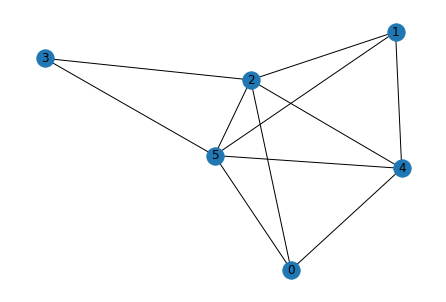

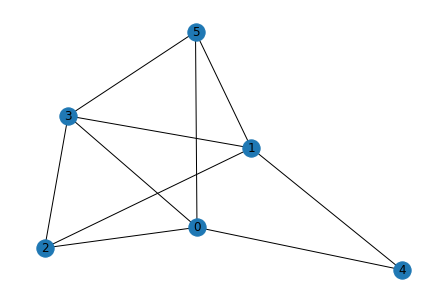

In [30]:
solution, (G1, G2) = tester(6)
z_1=nx.to_numpy_array(G1).astype(int)
z_2=nx.to_numpy_array(G2).astype(int)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
LC operations needed on nodes: [0, 1, 3, 2]
True
True


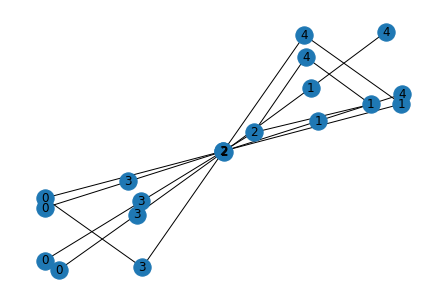

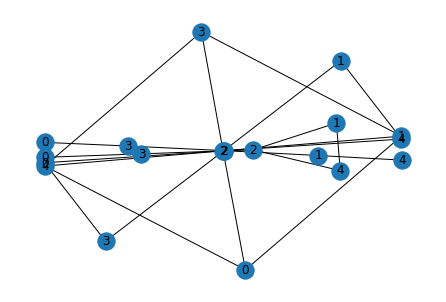

In [25]:
g_list=LC_graph_operations(z_1, solution)
print("LC operations needed on nodes:",g_list)
G_new = G1
for i in g_list:
    G_new = Local_comp_graph(G_new,i)
    
z_new = nx.to_numpy_array(G_new)
z_2=nx.to_numpy_array(G2).astype(int)
print(nx.is_isomorphic(G_new, G2))
print(np.array_equal(z_new, z_2))

True


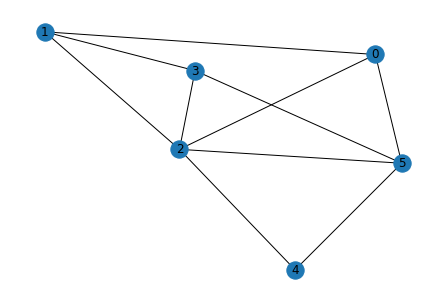

In [18]:
nx.draw(G2, with_labels = True)
print(nx.is_isomorphic(G_new, G2))